# Leaf Classification
Author: Andreas Bleyel \
Kaggle-URL: https://www.kaggle.com/c/leaf-classification

## Einführung
Pflanzenblätter enthalten wichtige Merkmale wie Formen, Farben, Texturen sowie Strukturen ihres Blattes, deren Rinde, Blume und auch des Keimlings. All diese sind nützlich, um die Spezies der Pflanze zu klassifizieren. Ziel dieser Competition ist es, mit Hilfe von drei spezifischen Features (Form, Rand und Textur) welche als numerische Vektoren mit je 64 Elementen vorliegen, einzelne Blätter zu einer von 99 Spezien zuzuordnen.

### Beschreibung des Datensatzes:
Der Datensatz besteht aus 1584 Einträgen wovon sich 990 bereits gelabelte Einträge im Trainingsdatensatz befinden und die restliche 594 als ungelabelte Testdatensätze verbleiben. Zu jedem Datensatz gibt es 3 Feature-Sets welche Vektoren mit je 64 Elementen darstellen. In beiden Datensätzen gibt es noch ein ID Feld als eindeutigen Identifizierer. 

* ID
* species (nur Trainingsdatensatz) - angestrebte Prädiktion ŷ
* margin_1, margin_2, margin_3, ..., margin_64
* shape_1, shape_2, shape_3, ..., shape_64
* texture_1, texture_2, texture_3, ..., texture_64

Für eine detailierte Beschreibung warum die genannten Features zur Klassifizierung herangezogen werden und wie die Vektoren berechnet werden, wird auf die Arbeit von Charles Mallah et al. Sektion 4.1 - 4.3 [1] verwiesen.

> [1] Mallah, C., Cope, J., & Orwell, J. (2013). Plant leaf classification using probabilistic integration of shape, texture and margin features. Signal Processing, Pattern Recognition and Applications, 5(1).

Zusätzlich zu diesen beiden Datensätzen im csv Format, gibt es auch noch 1584 Bilder zu je 16 Bilder pro Spezies (99 Spezien gesamt). Diese Bilder wurden in binäre schwarz/weiß Bilder konvertiert so das ein weißes Blatt auf schwarzem Hintergrund zu sehen ist. Der Dateiname jedes Bildes, stellt die dazugehörende ID aus dem Trainings- oder Testdatensatz dar. Die Bilder selbst wurden jedoch nicht gelabelt bzw. in Test/Trainings unterteilt (wie dies bei den Vektoren der Fall ist) und befinden sich alle im selben Ordner. Möchte man mit den Bildern arbeiten, ist somit eine Vorverarbeitung notwendig.

### Zielsetzung und angewandte Methoden
Für die Klassifizierung stehen uns somit ein kombinierter Vektor mit 192 Elementen und/oder ein schwarz/weiß Bild zur Verfügung. Da alle einsehbaren Notebooks auf Kaggle mit den Vektoren arbeiten und die Bilddaten ignoriert werden, möchte ich die Bilddaten nutzen um ein Convulutional Neural Net zur Klasseneinteilung zu trainieren. Die besten Lösungen auf Kaggle erreichen allesamt einen Score von log-loss 0.0 was bedeutet, dass alle Vorhersagen korrekt waren. Eine genauerer Beschreibung der Bewertung und welche Implikationen dies für unser gewähltes Modell hat, ist in Sektion `Model Evaluation` beschrieben.

### Erstellen eines Train/Test Datensatzes für die Klassifikation durch Bilddaten
Die im Datensatz enthaltenen Bilder sind nicht nach Train/Test sortiert oder gelabelt. Diese Verbindung besteht nur über den Dateinamen und die ID in den csv Dateien. Eine Verbindung muss daher manuell hergestellt werden. Dies geschieht in weiterer Folge über das Abgleichen des Dateinamens mit den ID's welche in den beiden csv Dateien enthalten sind. Dazu wird dann die Bilddatei eingelesen und insgesamt 3 Arrays erstellt. 'img_id' hält die ID/Dateiname, 'img' die Bilddaten und 'img_species' den kategoriellen Wert der Species für alle Bilder deren ID im Trainingsdatensatz enthalten sind. Die Indexe dieser 3 Arrays zeigen jeweils auf das selbe Bild. Dies müssen dann noch in gelabelte (Train) und ungelabelte (Test) Bilder aufgesplittet werden. Der daraus resultierende Trainingsdatensatz, wird dann nochmals in einen Trainings- und Validationssatz geteilt.

## Data Loading
Der erste Schritt besteht im Laden der beiden csv Dateien sowie aller Bilder und der Überprüfung, ob die Datensätze zur weiteren Verwendung bereit sind.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt
from matplotlib import pyplot as plt

from helper_functions import *

In [2]:
np.random.seed(1810837059)

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
checkDatasetNAs(train)

No NAs in Dataset


In [4]:
checkDatasetNAs(test)

No NAs in Dataset


In [5]:
train.head(3)

,id,species,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
0,1,Acer_Opalus,0.007812,0.023438,0.023438,0.003906,0.011719,0.009766,0.027344,0.0,...,0.007812,0.0,0.002930,0.002930,0.035156,0.0,0.0,0.004883,0.000000,0.025391
1,2,Pterocarya_Stenoptera,0.005859,0.000000,0.031250,0.015625,0.025391,0.001953,0.019531,0.0,...,0.000977,0.0,0.000000,0.000977,0.023438,0.0,0.0,0.000977,0.039062,0.022461
2,3,Quercus_Hartwissiana,0.005859,0.009766,0.019531,0.007812,0.003906,0.005859,0.068359,0.0,...,0.154300,0.0,0.005859,0.000977,0.007812,0.0,0.0,0.000000,0.020508,0.002930


In [6]:
test.head(3)

,id,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,margin9,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
0,4,0.019531,0.009766,0.078125,0.011719,0.003906,0.015625,0.005859,0.0,0.005859,...,0.006836,0.0,0.015625,0.000977,0.015625,0.0,0.0,0.000000,0.003906,0.053711
1,7,0.007812,0.005859,0.064453,0.009766,0.003906,0.013672,0.007812,0.0,0.033203,...,0.000000,0.0,0.006836,0.001953,0.013672,0.0,0.0,0.000977,0.037109,0.044922
2,9,0.000000,0.000000,0.001953,0.021484,0.041016,0.000000,0.023438,0.0,0.011719,...,0.128910,0.0,0.000977,0.000000,0.000000,0.0,0.0,0.015625,0.000000,0.000000


In [3]:
print(train.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 990 entries, 0 to 989
Columns: 194 entries, id to texture64
dtypes: float64(192), int64(1), object(1)
memory usage: 1.5+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594 entries, 0 to 593
Columns: 193 entries, id to texture64
dtypes: float64(192), int64(1)
memory usage: 895.7 KB
None


Das Datenset ist vollständig und die Datentypen der Vektoren-Werte sind numerisch. Lediglich die Skalierung der Vektoren-Werte sowie die die Kategorisierung der Ziel Variable sind notwendig. Die zur Verfügung gestellten numerischen Daten wurden bereits im Verhätnis 62,5/37,5 in test und train Sets aufgeteilt. Jede Spezies ist genau 10x im Trainings Datensatz enthalten. 

In [4]:
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit

In [5]:
# Einlesen, encoding und gleichzeitige Skalierung der Trainings- und Testdaten.
# Weiters wird ein Dict erstellt, welches zu jeder Klasse die Nummer(gemäß des kategoriellen Wertes) und die Bezeichnung hält.  
def load_numeric_training(data, standardize=True):
    ID = data.pop('id')

    # Encoding der Species-Labels zu kategoriellen Werten
    y = data.pop('species')
    x = y.copy()
    y = LabelEncoder().fit(y).transform(y)
    
    # Anlegen eines Dicts welches die Bezeichnung der Spezies zur Kategorie hält
    kat_species = {}
    for index, species in enumerate(x):
        kat_species[y[index]] = species 
    
    # Standardisierung - Mean = 0, STD = 1
    X = StandardScaler().fit(data).transform(data) if standardize else data.values

    # Zu jeder Zeile Rückgabe von ID, aufbereiteten Vektoren-Werte und kategorieller Spezies
    return ID, X, y, kat_species

def load_numeric_test(data, standardize=True):
    ID = data.pop('id')
    # Standardisierung - Mean = 0, STD = 1
    X_test = StandardScaler().fit(data).transform(data) if standardize else data.values
    
    # Zu jeder Zeile Rückgabe von ID und aufbereiteten Vektoren-Werte
    return ID, X_test

In [6]:
ID_train, X_num_train, y_num_train, kat_species_dict = load_numeric_training(train)
ID_test, X_num_test = load_numeric_test(test)
kat_species_dict = dict(sorted(kat_species_dict.items()))

Als nächstes werden die Bilder eingelesen und dazu eine Liste mit den dazugehörigen IDs erstellt. Ziel ist es, dass die Indizes der beiden Listen zusammengehören und eine Liste die Bilddaten und die andere Liste die dazugehörige ID am selben Index hält. Jedes Bild wird im Anschluss mit einer dritten Liste verknüpft welche ebenfalls am passenden Index den kategoriellen Wert der zugehörigen Spezies hält. 

Siehe nachfolgendes Beispiel:

* img_ids - hält die IDs
* images - hält die Pixelwerte der einzelnen Bilder
* imgs_species - hält den kategoriellen Wert der Spezies (None falls die Bild-ID im Testdatensatz enthalten ist)

| Index | img_ids |          images         | imgs_species |
|:-----:|:-------:|:-----------------------:|:------------:|
|   0   |    2    | PixelWwerte [[0 0 255]] |      49      |
|   1   |   1226  |      PW [[0 0 255]]     |      97      |
|   2   |   152   |      PW [[0 0 255]]     |      97      |

### Wichtig: Für Reproduzierbarkeit muss die `ROOT_PATH` Variable angepasst werden

In [7]:
import skimage.data
import skimage.transform
import re
# ANPASSEN #
ROOT_PATH = "/home/andi/Documents/FH/DSIA-MsC/3Sem/Data Science for Natural Science/Leaf Classification"
#############
img_data_dir = os.path.join(ROOT_PATH + "/leaf-img")
print(img_data_dir)

/home/andi/Documents/FH/DSIA-MsC/3Sem/Data Science for Natural Science/Leaf Classification/leaf-img


In [8]:
def load_imgs():
    images = []
    str_ids = []
    ids = []
    # Einlesen aller jpg Files des Image Ordners
    files = [i for i in os.listdir(img_data_dir) if i.endswith("jpg")]    
     
    for file in files:
        images.append(skimage.data.imread(os.path.join(img_data_dir, file)))
        str_ids.append(re.sub('.jpg', '', file))
        
    ids = list(map(np.int64, str_ids))
    return images, ids

In [9]:
images, imgs_ids = load_imgs()

Somit haben wir jetzt 2 Listen in welcher einerseits das Bild, andererseits die ID abgespeichert sind und am selben Index liegen. Die Bilder werden durch `skimage` unter folgendem Format als numpy Array abgespeichert: Anzahl Pixel Höhe, Anzahl Pixel Breite. Farbkanäle gibt es in diesem Fall keine da es sich um binäre Bilder handelt.

Überprüfung ob das Einlesen funktioniert hat: 

In [13]:
print("Bild mit ID {0} hat eine Abmessung von {1}x{2}".format(imgs_ids[1], images[1].shape[0], images[1].shape[1]))
print("Anzahl IDs: {0}\nAnzahl Bilder: {1}".format(len(imgs_ids), len(images)))

Bild mit ID 1226 hat eine Abmessung von 357x642
Anzahl IDs: 1584
Anzahl Bilder: 1584


Die nächste Funktion soll sicherstellen, dass die Bilder tatsächlich im binären Format vorliegen. Bei einem der ersten Durchgänge fiel auf, dass Werte abweichend von 0/255 in den Bildern vorkamen weshalb diese Überprüfung eingeführt wurden.

In [10]:
def check_all_img_binary(img_data):
    for img in img_data:
        for row in img:
            for value in row:
                if 0 < value < 255:
                    print("Different values occur")
                    print("Value: " + str(value))
                    print(type(value))
                    return
    print("All images have values 0 or 255")

In [11]:
check_all_img_binary(images)

Different values occur
Value: 1
<class 'numpy.uint8'>


Obwohl die Bilder als binäre Bilder in der Competition betitelt wurden, sind Werte abweichend von 0 bzw. 255 vorhanden (Grauwerte). Im späteren Verlauf werden die Bilder in der Größe verändert und gleichzeitig findet eine Skalierung der Werte statt. Dieser Schritt wird dann auch genutzt, um die Pixelwerte welche noch von 0/255 abweichen zu korrigieren.

Als nächstes wird eine Liste `img_species` angelegt welche die kategoriellen Werte für jedes Bild welches im numerischen Datenset im Train-Set enthalten ist, am passenden Index den Wert der Species hält. Ist an einem beliebigen Index in `img_species` der Wert `None` hinterlegt, befindet sich die ID (und somit auch das Bild) nicht im Train-Datensatz. Die Liste welche alle Bilder enthält, muss danach noch in ein Test/Training Liste geteilt werden. Dies geschieht aber erst später nachdem die Bilder resized wurden.

In [12]:
def create_img_species_list():  
    imgs_species = [None] * len(imgs_ids)
    # Liste ID_train durchlaufen und ... 
    for ind_id_train, value in enumerate(ID_train):
        # jede ID aus ID_train in der ID-Liste der Bilder finden
        for ind_img_id, img_id in enumerate(imgs_ids):
            # wenn gefunden ...
            if value == img_id:
                # am Index der ID-Liste der Bilder, in der img_species den kategoriellen Wert aus y_num_train einfügen
                imgs_species[ind_img_id] = y_num_train[ind_id_train]
    return imgs_species

imgs_species = create_img_species_list()
#print(len(imgs_species))

Überprüfung ob einzelne Bilder richtig zugewiesen wurden und die Indexe der einzelnen Arrays auch auf das selbe Bild verweisen.

In [13]:
print("Bild mit ID {0} hat eine Abmessung von {1}x{2}, SpeciesKat: {3}, SpeciesName: {4}"
      .format(imgs_ids[278], images[278].shape[0], images[278].shape[1], imgs_species[278], kat_species_dict[imgs_species[278]]))

print("Bild mit ID {0} hat eine Abmessung von {1}x{2}, SpeciesKat: {3}, SpeciesName: {4}"
      .format(imgs_ids[1], images[1].shape[0], images[1].shape[1], imgs_species[1], kat_species_dict[imgs_species[1]]))

print("Bild mit ID {0} hat eine Abmessung von {1}x{2}, SpeciesKat: {3}, SpeciesName: {4}"
      .format(imgs_ids[732], images[732].shape[0], images[732].shape[1], imgs_species[732], kat_species_dict[imgs_species[732]]))

Bild mit ID 2 hat eine Abmessung von 251x667, SpeciesKat: 49, SpeciesName: Pterocarya_Stenoptera
Bild mit ID 1226 hat eine Abmessung von 357x642, SpeciesKat: 97, SpeciesName: Viburnum_x_Rhytidophylloides
Bild mit ID 152 hat eine Abmessung von 364x611, SpeciesKat: 97, SpeciesName: Viburnum_x_Rhytidophylloides


Nachdem die Bilder eingelesen wurden und eine Verbindung zwischen Bild und Spezies besteht, wird eine Übersicht jeder Klasse samt eines Beispielsbildes in originaler Auflösung ausgegeben.

In [14]:
import matplotlib.pyplot as plt

def display_images_and_species(list_images, save = False):
    """
        Zeigt ein Bild jeder Species an. 
        Als Bildüberschrift ist die Spezies samt dazugehöriger kategorieller Nummer zu sehen.
        Wird save auf True gesetzt, wird der erzeugte Plot zusätlich als PNG Datei mit dem Namen der jeweiligen Bildgröße gespeichert.
    """
    unique_species = set(y_num_train)
    plt.figure(figsize=(25, 25))
    i = 1
    for species in unique_species:
        image = list_images[imgs_species.index(species)]
        plt.subplot(10, 10, i)
        plt.axis('off')
        plt.title(kat_species_dict[species] + " K:" + str(species))
        i += 1
        _ = plt.imshow(image)
    if save:
        name = str(list_images[0].shape[0])
        name = name + '.png'
        plt.savefig(name)
    else:
        plt.show()

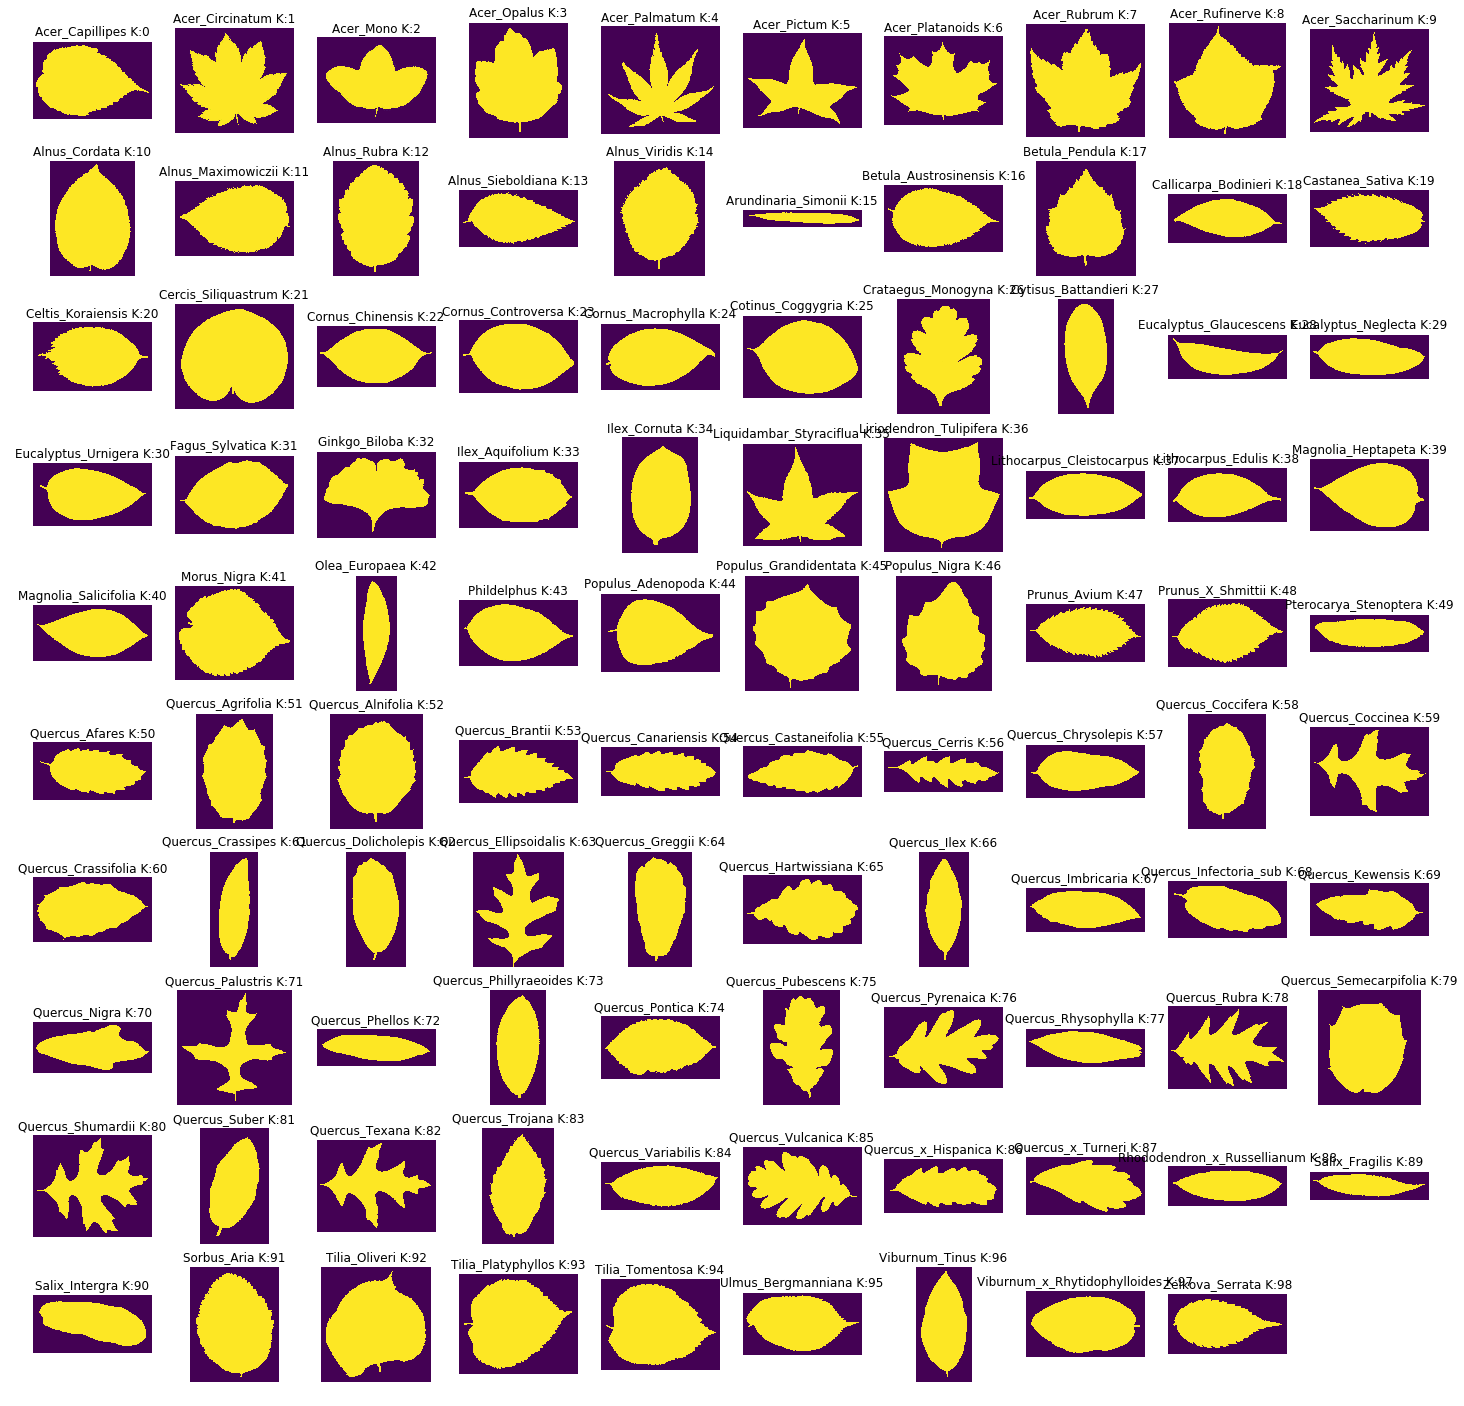

In [15]:
display_images_and_species(images)

Die Bilder weisen eine gute Qualität auf, jedoch variiert die Größe der Bilder weshalb es notwendig ist, alle auf die gleiche Größe zu formatieren. Unser CNNet erwartet Inputs fixer Größe. Um die Bilder alle auf die gleiche Größe zu bringen kann man diese entweder an den Rändern abschneiden oder als Ganzes skalieren. Beim abschneiden könnten wir wichtige Merkmale verlieren weshalb wir den anderen Weg wählen. Durch das Skalieren, wird zwar das Bild verzerrt, aber es bleiben alle Merkmale vorhanden.

In [21]:
x, y = 0,0
for image in images: 
    x += image.shape[0]
    y += image.shape[1]
print("Avg: {0}*{1}".format(round(x/len(images),2), round(y/len(images),2)))

Avg: 493.11*693.33


Die Bilder weißen im Durchschnitt eine Größe von 493*693 auf. Ich möchte es aber zuerst mit einem quadratischen Format und einem Wert welcher einer Quadratsumme von 2 entspricht probieren. Da ich die Bilder nicht vergrößern sonder verkleinern möchte (spart Ressourcen, kann bei schlechter Performance des NNs wieder geändert werden), wähle ich 32x32.

Nachfolgende Zelle enthält diverse Funktionen welche für die Vorverarbeitung der Bilder und die Generierung eines Test und Trainingsdatensatzes, gemäß der beiden csv Dateien, notwendig sind.

In [16]:
def resize_images(size): 
    '''
        Ändert die Größe der Bilder gemäß übergebenem Parameter
    '''
    return [skimage.transform.resize(image, (size, size), mode='constant')
                for image in images]

def have_same_size(images):
    '''
        Prüft ob alle Bilder in übergebenem Array die gleichen Abmessungen besitzen
    '''
    x = images[0].shape[0]
    y = images[0].shape[1]

    for image in images: 
        if not image.shape[0] == x and image.shape[1] == y:
            print("Not all images have the same size")
            return

    print("All images are the same size: {0}x{1}".format(x, y))
    
def convert_images_to_binary(img_data):
    '''
        Konvertiert Bilder aus übergebenem Array(welche keinen absoluten RGB Werte sonder bereits skalierte Werte zwischen 0-1 enthalten)
        zu binären Bildern. Als Grenzwert ist 0.5 definiert.
    '''
    for img in img_data:
        for ir, row in enumerate(img):
            for iv, value in enumerate(row):
                if value > 0 and value < 0.5:
                    img[ir][iv] = 0
                elif value >= 0.5  and value < 1:
                    img[ir][iv] = 1
                    
def split_images_train_test():
    '''
        Teilt die Bilder in die selben Trainings und Testdatensätze auf, wie sie in den beiden csv Dateien enthalten sind.
    '''
    img_train = []
    img_train_species = []
    img_train_file_name = []
    
    img_test = []
    img_test_file_name = []

    for index, value in enumerate(imgs_species):
        if value:
            img_train.append(images_resized_bin[index])
            img_train_species.append(value)
            img_train_file_name.append(imgs_ids[index])
        else:
            for iid in ID_test:
                if imgs_ids[index] == iid:
                    img_test.append(images_resized_bin[index])
                    img_test_file_name.append(imgs_ids[index])

    return img_train, img_train_species, img_train_file_name, img_test, img_test_file_name

### Vorverarbeitung der Bilder
Der Parameter `image_size` gibt die gewünschte Höhe und Breite an. Die Bilder werden auf diese Größe skaliert, zu binären Bildern konvertiert und in train/test Sätze aufgeteilt. Die Konvertierung zu binären Bilder ist deshalb notwendig, da die Bilder (obwohl von Kaggle so beschrieben) nicht zu 100% binär waren. Leichte Grauwerte an den Rändern waren enthalten.

Anschließend wird der Trainingsdatensatz nochmal in train und validation unterteilt. Nach erfolgter Aufteilung der Bilder in gelabelte (Train) und ungelabelte (Test) Datensätze, können wir diese nun in ein Format bringen, welches als Input für ein NNetz dient. Aus dem erzeugten gelabelten Trainingsdaten, lösen wir davor noch ein Validation-Set von 25% heraus. Der ungelabelte Test-Datensatz, wird im Abschluss für eine Prediction verwendet von welcher das Ergebnis für die Kaggle Competition hochgeladen und dort der Score unseres CNNet evaluiert wird.

In [30]:
# Gewünschte Abmessung
image_size = 32
images_resized = resize_images(image_size)

# Konvertierung zu binären Bildern
images_resized_bin = images_resized.copy()
convert_images_to_binary(images_resized_bin)

# Aufteilung in train/test
img_train, img_train_species, img_train_file_name, img_test, img_test_file_name = split_images_train_test()

# Aufteilung des train-Sets in train und validation
from sklearn.model_selection import train_test_split
X_train_img, X_val_img, y_train_img, y_val_img = train_test_split(img_train, img_train_species, test_size=0.25, random_state=42)

# Umwandlung von Listen zu Arrays
X_train_img = np.array(X_train_img)
X_val_img = np.array(X_val_img)
y_train_img = np.array(y_train_img)
y_val_img = np.array(y_val_img)

img_test = np.array(img_test)
img_test = img_test.reshape(len(img_test), image_size, image_size, 1)

# Anpassung der Shape für das NNetz
X_train_img = X_train_img.reshape(735, image_size, image_size, 1)
X_val_img = X_val_img.reshape(245, image_size, image_size, 1)

# Umwandlung der train/valdation Sets in kategorielle Variablen für das NNetz
from keras.utils import to_categorical
y_train_img_cat = to_categorical(y_train_img)
y_val_img_cat = to_categorical(y_val_img)

Nochmals die Ausgabe jeder Klasse samt Beispielbild, jedoch in der verkleinerten Version.

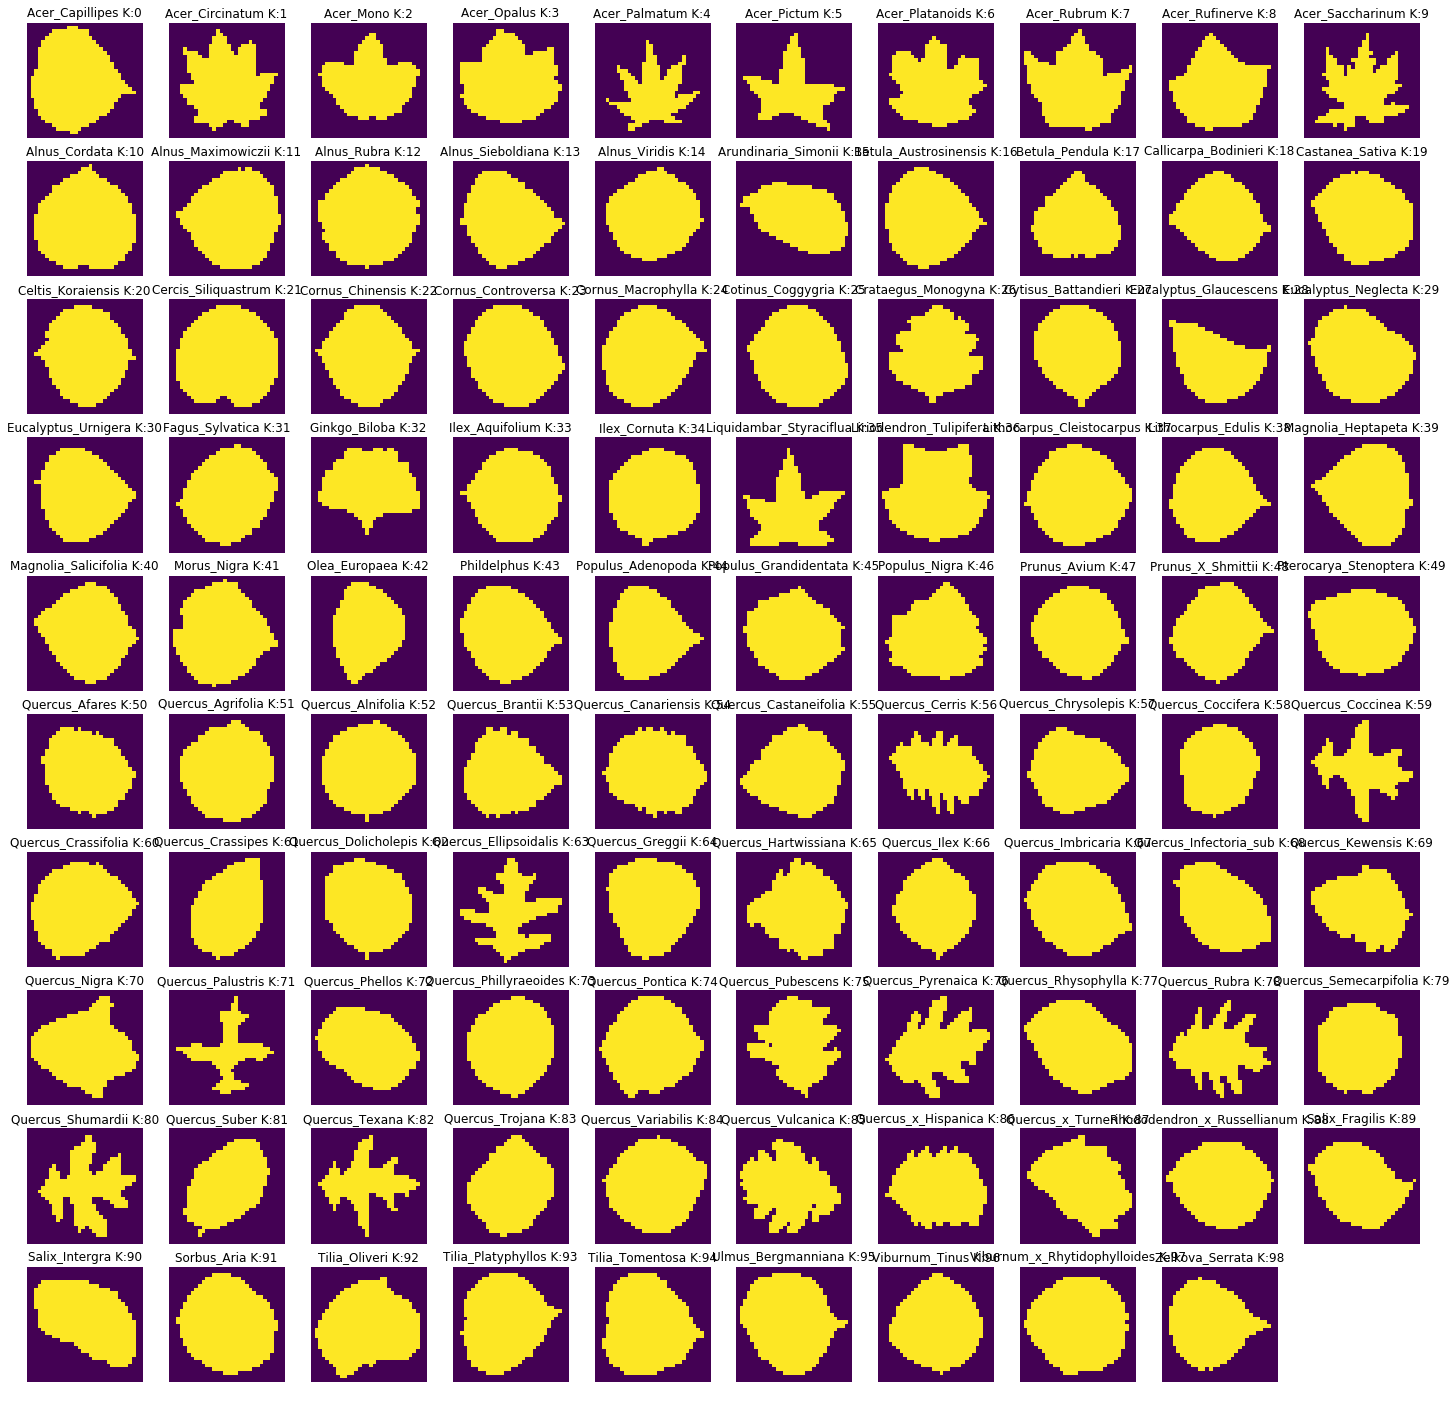

In [18]:
display_images_and_species(images_resized_bin)

Wie man sieht, sind die Kanten der Bilder deutlich unschärfer und einige Kategorien verlieren ihre signifikante Form. Besonders auffällig ist dies zB. bei der Spezies `K:15  Arundinaria_Simonii Bildname 37.jpg`. Die Blätter zeichnen sich durch ihre sehr schmale und längliche Form aus welche durch das resizen eigentlich komplett verloren geht. Dies wird vermutlich die Performance des NN beeinträchtigen was eine höhere Auflösung notwendig macht. Es wird interessant zu sehen welche Auflösung als Minimum für eine akzeptable Genauigkeit von Nöten sein wird.

Überprüfung ob das Skalieren erfolgreich war:

In [19]:
have_same_size(images_resized_bin)

All images are the same size: 32x32


In [20]:
for image in images_resized_bin[:5]:
    print("shape: {0}, min: {1}, max: {2}".format(image.shape, image.min(), image.max()))

shape: (32, 32), min: 0.0, max: 1.0
shape: (32, 32), min: 0.0, max: 1.0
shape: (32, 32), min: 0.0, max: 1.0
shape: (32, 32), min: 0.0, max: 1.0
shape: (32, 32), min: 0.0, max: 1.0


Was in der obigen Ausgabe auffällt ist, dass die Werte plötzlich nicht mehr 0 oder 255 betragen, sonder 0 oder 1. Die Funktion resize() war so nett und hat bereits die Skalierung durchgeführt was uns beim Trainieren des NNetzes zu Gute kommen wird.

Folgende Ausgaben dienen der stichprobenartigen Kontrolle ob die Zuweisung der Bilddaten zu den einzelnen Sets auch korrekt war.

In [21]:
print("Bild mit Index 1 im Train-Set hat SpeciesKat: {0}, SpeciesName: {1} und File-Name: {2}"
      .format(img_train_species[1], kat_species_dict[img_train_species[1]], img_train_file_name[1]))

print("Bild mit Index 1 im Test-Set File-Name: {0}"
      .format(imgs_ids[img_test_file_name[1]]))

Bild mit Index 1 im Train-Set hat SpeciesKat: 76, SpeciesName: Quercus_Pyrenaica und File-Name: 1089
Bild mit Index 1 im Test-Set File-Name: 1464


## Erstellen des Neuronalen Netzes

Für die Klassifizierung wird ein CNNet gewählt. Dieses besteht in weiterer Folge aus mehreren Instanzen von Schichten (In weiterer Folge als Layer bezeichnet). Als ersten Layer wird ein Layer vom Typ Convolutional2D gewählt. Da dies der erste Layer ist, muss die `input_shape` definiert werden. In unserem Fall, entspricht dies den Dimensionen unseres Bildes wie zum Beispiel 32x32x1 - Höhe, Breite, Anzahl Kanäle (1 da binär). Die Anzahl der Filter wird als Vielfaches von 2 gewählt und steigt mit jedem Layer an. Dies bedeutet, dass das NNetz mit jedem Layer auf kleinere Details achtet. Zu Beginn werden nur die gröbsten Merkmal erfasst und diese dann in jedem weiteren Layer genauer betrachtet und zusammengefasst. `kernel_size` wird mit 3x3 gewählt was für unsere relative kleinen Bilder gut geeignet scheint. Aus dem selben Grund, wird auch der Pooling-Layer mit 2x2 gewählt. Vor dem Output-Layer welcher als Activation-Funktion `softmax` nutzt (um eine Wahrscheinlichkeit für jede Klasse, welche aufsummiert 1 ergibt, zu erzeugen) wird noch ein Hiddenlayer (Dense) eingeführt um den Dropout-Layer welcher Overfitting verhindern soll, nutzen zu können. Die Dropout Rate wurde gemäß [2] mit 0.5 gewählt.

> [2] Hinton, G. E., Srivastava, N., Krizhevsky, A., Sutskever, I., & Salakhutdinov, R. R. (2012). Improving neural networks by preventing co-adaptation of feature detectors. arXiv preprint arXiv:1207.0580.

In [23]:
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Conv2D, MaxPool2D, Flatten, Activation, Dense, Dropout
from keras.models import Sequential

In [24]:
model1 = Sequential()

model1.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=(image_size, image_size, 1)))
model1.add(MaxPool2D(pool_size=(2,2)))
model1.add(Conv2D(64, kernel_size=3, activation='relu'))
model1.add(MaxPool2D(pool_size=(2,2)))
# Bringt keine Verbesserung
#model1.add(Conv2D(128, kernel_size=3, activation='relu'))
#model1.add(MaxPool2D(pool_size=(2,2)))
model1.add(Flatten())
model1.add(Dense(150))
model1.add(Dropout(0.5)) 
model1.add(Activation('relu'))
model1.add(Dense(99))
model1.add(Activation('softmax'))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Bevor das Modell trainiert werden kann, müssen noch einige Parameter mittels `compile` definiert werden wie das Modell trainiert werden soll. Als Optimizer wurde `adam` gewählt da er  als sehr zuverlässig bei gleichzeitig moderatem Speicherverbrauch gilt[3]. Da wir ein Mehrklassen-Problem haben bei dem nur eine Klasse pro Beobachtung richtig ist, wird als loss-Funktion `categorical_crossentropy` gewählt und als Metric die Genauigkeit der Einteilung.

> [3] Kingma, D. P., & Ba, J. (2014). Adam: A method for stochastic optimization. arXiv preprint arXiv:1412.6980.

In [25]:
model1.compile(
    optimizer='adam',
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

In [26]:
%%time
history = None
history = model1.fit(
    X_train_img,
    y_train_img_cat,
    epochs=50,
    verbose=0,
    batch_size=70
    ,validation_data=(X_val_img, y_val_img_cat)
)

Instructions for updating:
Use tf.cast instead.
CPU times: user 2min 1s, sys: 2.56 s, total: 2min 4s
Wall time: 37.6 s


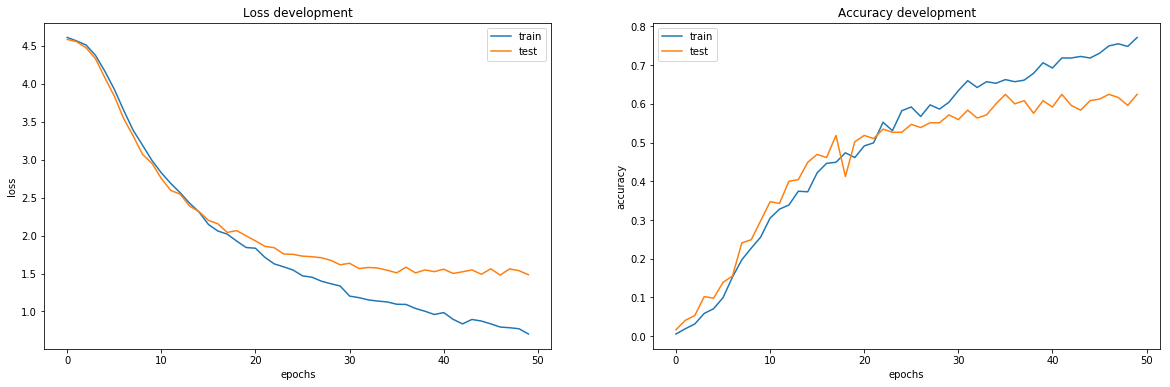

In [27]:
plot_history(history)

Ein erster Versuch mit einer Auflösung von 32x32 zeigt, dass das Modell noch sehr ungenau arbeitet (ab Epoche 50 keine Verbesserung mehr der Genauigkeit von ~55% auf dem Validation Set) was vermutlich an der zu geringen Auflösung der Bilder liegt. In weiterer Folge wird das selbe Modell mit Bildern höherer Auflösung trainiert und die Genauigkeiten verglichen. Ziel ist es, die geringstmögliche Auflösung zu finden bei der noch passable Ergebnisse erzielt werden. Dafür werden die duch das NNetz errechneten Klassenwahrscheinlichkeiten eines jeden Test-Bildes addiert und daraus der Durchschnitt gebildet. So sehen wir, wie "sicher" das Netz über den gesamten Test Datensatz ist, die richtige Klasse gewählt zu haben. Anmerkung: Dies besagt aber nicht, dass das NNetz auch die tatsächlich richtige Klasse gewählt hat. Sollte das Modell sich zu 99% sicher sein, dass ein Bild der Klasse X angehört, tatsächlich aber der Klasse Y entstammt, wird das den Wert nicht senken und noch dazu, den log-loss stark verschlechtern.

In [34]:
def show_statistics_for_prediction(predictions, save=False):
    # speichert für jede Vorhersage den prozentuellen Wert der gewählten Klasse
    # wie sicher war sich das NNetz beim Einteilen der Test-Bilder generell
    max_values = []
    
    # speichert für jeden Vorhersage die Wahrscheinlichkeit der gewählten Klasse und ordnet diese nach Klasse ein
    # Keys von 0-99 - Values als Arrays welche die Wahrscheinlichkeit halten mit welcher die Beobachtung in die entsprechende Klasse eingeteilt wurde
    confidences_per_kat = {key: [] for key in kat_species_dict.keys()}
    
    # Hält zu jeder Kategorie die Anzahl an Vorhersagen welche für diese Kategorie getroffen wurden. 
    # Ergibt sich aus der Länge des Value-Arrays aus dem confidences_per_kat Dictionary
    counter_kat = []
    
    # Halten den Durchschnitts bzw. Median der Wahrscheinlichkeitswerte pro Kategorie pro Testbild
    avg_per_kat = 99 * [0] #{key: 0 for key in kat_species_dict.keys()}
    med_per_kat = 99 * [0]
    
    # Halten den Durchschnitts bzw. Median der Wahrscheinlichkeitswerte der gewählten Kategorie pro Testbild
    avg_per_kat_predicted = []
    med_per_kat_predicted = []
    
    for prediction in predictions:
        max_values.append(prediction.max())
        confidences_per_kat[prediction.argmax()].append(prediction.max())
        
    max_values = np.array(max_values)    

    for i in range(99):
        avg_per_kat[i] = np.mean(predictions[:,i])
        med_per_kat[i] = np.median(predictions[:,i])
        
    for value in confidences_per_kat.values():
        if not value:
            avg_per_kat_predicted.append(0)
            med_per_kat_predicted.append(0)
        else:
            avg_per_kat_predicted.append(np.mean(value))
            med_per_kat_predicted.append(np.median(value))
           
        #print(avg_per_kat_predicted[0])

    for item in confidences_per_kat.values():
        counter_kat.append(len(item))
               
    print("Avg-Total Confidence: {0}%, Median-Total Confidence: {1}%".format(round(np.mean(max_values)*100,2), round(np.median(max_values)*100,2)))
    
    plt.rcParams["figure.figsize"] = (25, 25)    
    fig, ax = plt.subplots(3)
    
    ax[0].bar(confidences_per_kat.keys(), counter_kat, color="grey")
    ax[0].set(title="Anzahl an zugeordneter Test-Bilder je Spezies")
    ax[0].set(xlabel="Spezies", ylabel="Anzahl Zuordnungen");       
    plt.xticks(range(99))

    ax[1].bar(confidences_per_kat.keys(), avg_per_kat_predicted, color='blue')
    ax[1].set(title='Mean der Confidence je eingeteilter Spezies')
    ax[1].set(xlabel='Spezies', ylabel='Mean')

    ax[2].bar(confidences_per_kat.keys(), med_per_kat_predicted, color='green')
    ax[2].set(title='Median der Confidence je eingeteilter Spezies')
    ax[2].set(xlabel='Spezies', ylabel='Mean')

#    ax[1].bar(confidences_per_kat.keys(), avg_per_kat, color='blue')
#    ax[1].set(title='Mean der Confidence je Spezies über alle Bilder')
#    ax[1].set(xlabel='Spezies', ylabel='Mean')

#    ax[2].bar(confidences_per_kat.keys(), med_per_kat, color='red')
#    ax[2].set(title='Median der Confidence je Spezies über alle Bilder')
#    ax[2].set(xlabel='Spezies', ylabel='Median')

#    fig2, ax2 = plt.subplots()
#    ax2.set_title('Box Plot Klasse')
#    green_diamond = dict(markerfacecolor='g', marker='D')
#    ax2.boxplot(confidences_per_kat[24], vert=False, flierprops=green_diamond, sym='k.', showfliers=True)
    
    #print(confidences_per_kat[24])
    
    if save:
        plt.savefig('AnzZuordnungSpezies.png')

    plt.plot()
    
    return

In [31]:
# Nur notwendig wenn mit vorher gespeicherten Modellen gearbeitet wird
# Da das trainieren der einzelnen Modelle vorallem mit steigender Auflösung zeitintensiv ist, bietet es sich an
# diese zu speichern und bei Bedarf einfach zu laden.

#model1.save("32x32.h5")
#model1.save("64x64.h5")
#model1.save("128x128.h5")
#model1.save("192x192.h5")

#from keras.models import load_model
#model1 = load_model('m32x32.h5')
#model1 = load_model('m64x64.h5')
#model1 = load_model('m128x128.h5')
#model1 = load_model('m192x192.h5')

In [32]:
y_pred = model1.predict(img_test)


#50 Epochs
#32 1m9s 60.71%
#64 6m12s 77.97%
#128 22m0s 82.41%
#192 51m51s 77.59%
#256 acceeds allocation memory

Avg-Total Confidence: 66.3%, Median-Total Confidence: 67.6%
[0.1921609, 0.43986154, 0.69196016, 0.36687925, 0.19827329]


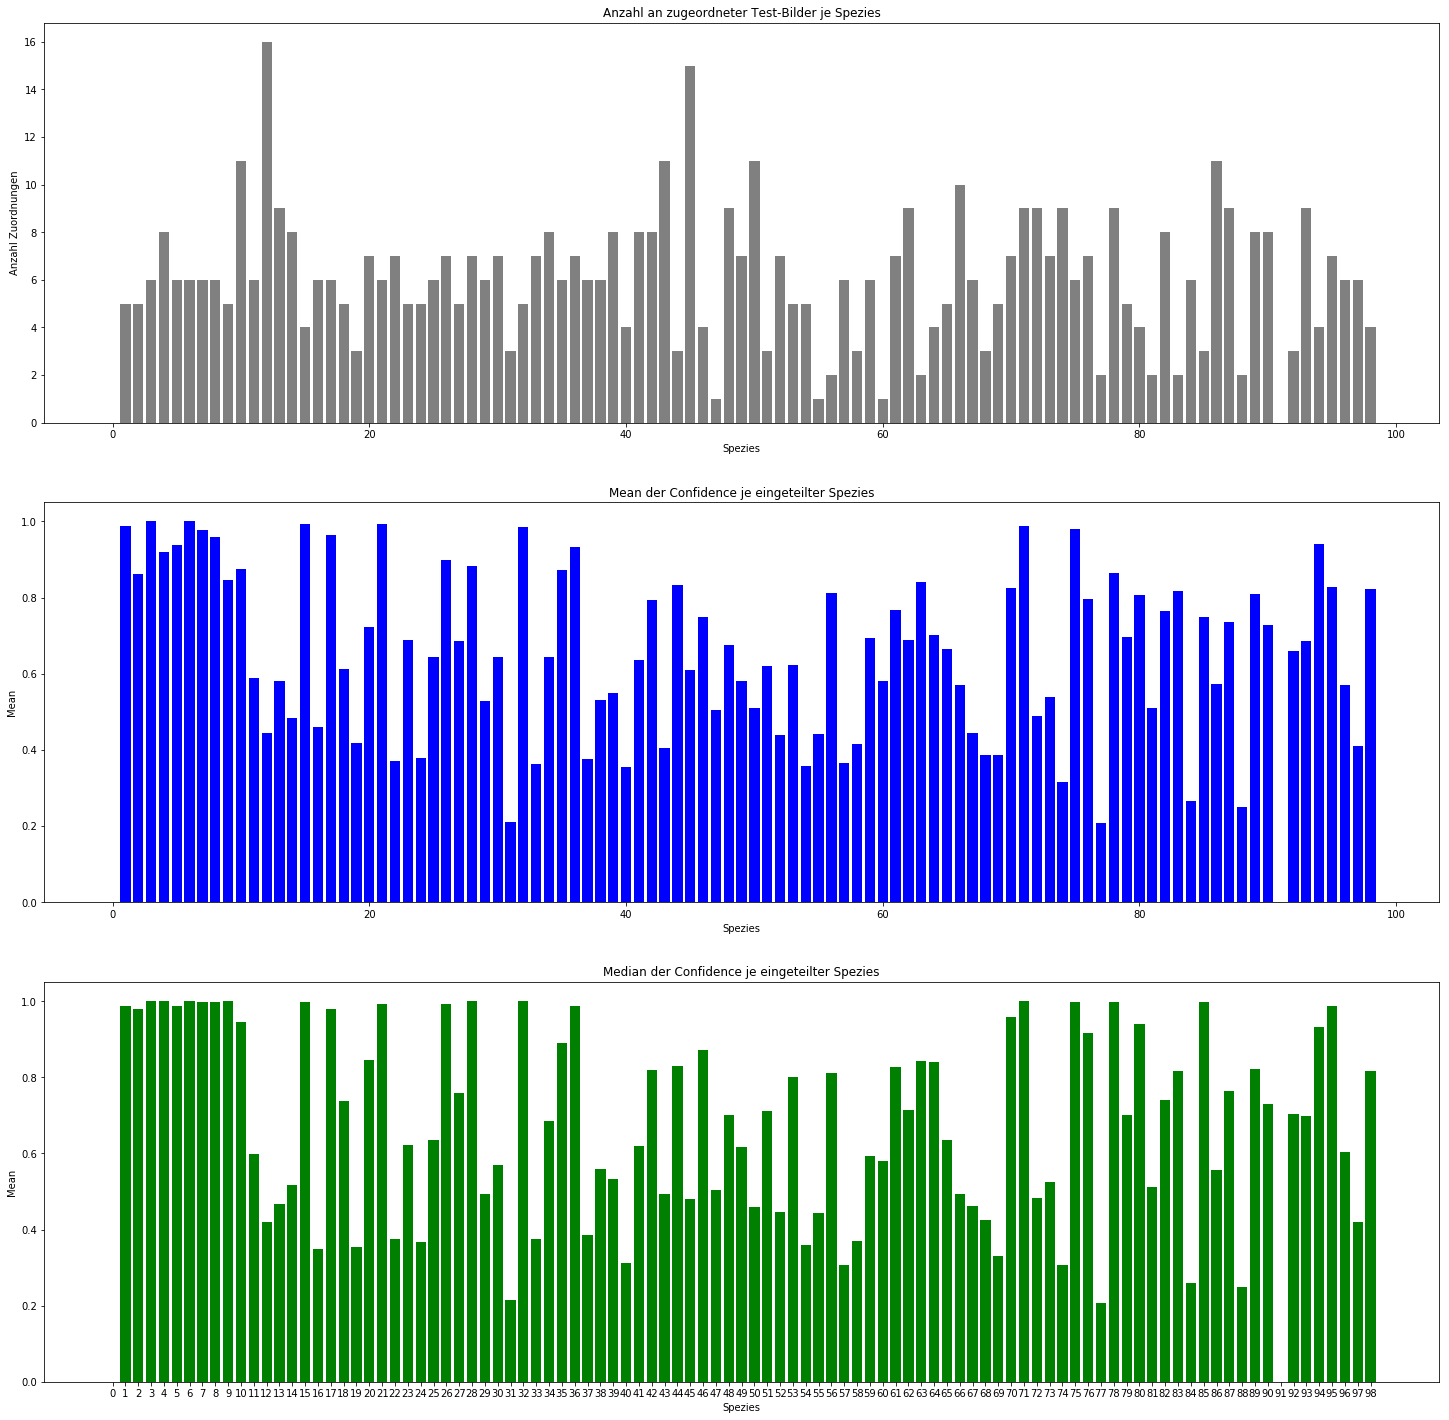

In [33]:
show_statistics_for_prediction(y_pred)

Überprüfung um sicherzustellen, dass die Zuweisung in die einzelnen Arrays samt Spezies Kategorie auch stimmt.

In [36]:
print("Bild mit Index 0 im Test-Set hat SpeciesKat: {0}, SpeciesName: {1}, FileName: {2}, Wshl: {3}%"
      .format(y_pred[0].argmax(), kat_species_dict[y_pred[0].argmax()], img_test_file_name[0], round(y_pred[0].max()*100,2)))

Bild mit Index 0 im Test-Set hat SpeciesKat: 17, SpeciesName: Betula_Pendula, FileName: 121, Wshl: 98.53%


In [37]:
print("Bild mit Index 1 im Test-Set hat SpeciesKat: {0}, SpeciesName: {1}, FileName: {2}, Wshl: {3}%"
      .format(y_pred[1].argmax(), kat_species_dict[y_pred[1].argmax()], img_test_file_name[1], round(y_pred[1].max()*100,2)))

Bild mit Index 1 im Test-Set hat SpeciesKat: 5, SpeciesName: Acer_Pictum, FileName: 977, Wshl: 99.97%


### Create Submission

In [121]:
yPred_df = pd.DataFrame(y_pred,columns=kat_species_dict.values())
yPred_df.insert(0, 'id', img_test_file_name)
yPred_df.reset_index()
yPred_df.tail()

,index,id,Acer_Capillipes,Acer_Circinatum,Acer_Mono,Acer_Opalus,Acer_Palmatum,Acer_Pictum,Acer_Platanoids,Acer_Rubrum,...,Salix_Fragilis,Salix_Intergra,Sorbus_Aria,Tilia_Oliveri,Tilia_Platyphyllos,Tilia_Tomentosa,Ulmus_Bergmanniana,Viburnum_Tinus,Viburnum_x_Rhytidophylloides,Zelkova_Serrata
0,0,121,3.307412e-10,1.182169e-04,1.990465e-04,2.344129e-07,5.671670e-11,8.426538e-08,1.638321e-07,1.118043e-04,...,3.454768e-09,1.011688e-08,6.160581e-11,1.939388e-05,2.071834e-11,1.942009e-12,2.634926e-12,2.898795e-04,8.106897e-14,1.093121e-08
1,1,977,1.223318e-13,1.699745e-08,7.760661e-08,3.146099e-11,9.777242e-07,9.997304e-01,3.899871e-07,4.072864e-10,...,6.453057e-09,6.507844e-11,7.066886e-13,2.163978e-13,1.405887e-16,6.926602e-14,1.785295e-14,3.318272e-13,2.555366e-15,9.091787e-12
2,2,1318,7.300044e-12,3.802105e-10,5.593022e-03,6.930142e-08,4.144919e-06,3.986857e-04,2.397681e-04,2.791285e-05,...,1.180202e-07,3.769911e-11,1.170074e-10,5.933281e-10,1.911764e-13,4.972053e-14,4.478235e-12,1.172869e-10,4.830861e-13,5.134303e-08
3,3,195,7.864955e-08,1.087348e-05,8.704832e-08,5.390141e-07,1.076297e-07,3.581279e-09,7.582009e-07,7.754356e-08,...,4.808874e-08,2.426147e-05,1.779414e-04,1.948956e-07,4.026809e-09,1.208691e-07,4.106264e-08,8.376639e-03,4.413686e-04,6.728834e-09
4,4,1389,2.103505e-07,1.717795e-06,1.623611e-06,1.529267e-06,5.454390e-06,7.417835e-08,4.037028e-06,2.555374e-05,...,2.261988e-04,9.820798e-11,6.826182e-05,1.246839e-07,5.893759e-04,9.669349e-08,4.721772e-03,2.004064e-03,3.616590e-07,2.717108e-04
5,5,696,2.450189e-08,6.592999e-08,1.975152e-09,1.512325e-05,8.461684e-09,1.775486e-09,2.618057e-07,1.439935e-07,...,1.979475e-08,1.966167e-05,3.474825e-04,3.623540e-05,2.086895e-07,4.516017e-06,5.439948e-06,4.470325e-03,1.098356e-02,1.076817e-07
6,6,1020,1.681425e-09,8.835106e-06,8.914839e-09,2.457807e-08,1.018899e-09,1.793442e-09,5.642694e-09,2.230503e-08,...,1.399808e-10,7.223657e-09,5.493640e-07,1.364130e-07,5.029300e-07,3.342700e-06,2.869677e-08,4.782800e-02,8.732402e-11,4.610669e-10
7,7,1510,7.863101e-08,3.971251e-08,2.147641e-07,1.137295e-06,4.045154e-08,8.008496e-08,3.658858e-08,2.900076e-08,...,7.985807e-06,4.109023e-04,1.792131e-03,5.810129e-04,3.300312e-08,4.892800e-07,1.032917e-06,1.134594e-02,1.899606e-05,5.732372e-08
8,8,1445,5.470422e-07,5.092582e-06,8.128216e-07,4.582966e-05,9.628765e-07,4.716336e-08,6.019626e-06,1.785855e-06,...,1.805760e-06,5.689061e-04,9.315304e-05,2.518899e-04,7.064795e-08,2.032670e-07,8.883073e-07,4.932730e-02,8.100076e-04,8.272503e-08
9,9,604,1.093248e-08,3.872513e-06,3.413898e-06,1.145795e-05,3.743998e-08,2.056764e-08,7.487661e-07,6.620857e-07,...,2.963457e-05,5.293720e-04,5.485953e-05,3.647489e-03,9.705733e-11,2.862867e-10,1.396146e-08,2.285352e-02,9.512623e-06,1.215140e-07


In [122]:
yPred_df.to_csv('submission.csv',index=False)

## Ergebnisse und Diskussion

### Model Evaluation
Neben dem Erreichen einer möglichst hohen Genauigkeit in der Vorhersage, war die Erreichung eines niedrigen `log-loss` relevant. Bei dieser Competition wird mittels `multi-class logarithmic loss` evaluiert. 

$$log loss = -\frac{1}{N}\sum_{i=1}^N\sum_{j=1}^My_{ij}\log(p_{ij}),$$ 

Angestrebt wird hierbei ein möglichst niedriger Wert. Teilt das Modell eine Beobachtung in eine falsche Klasse ein und ist sich dabei aber sehr sicher dass es richtig liegt, bekommt es einen höheren Penalty als wenn es in eine falsche Klasse einteilt, jedoch mit einer nicht so hohen Überzeugung (Prozentwert). Das gleiche gilt auch für richtige Einteilung. Den geringsten Loss erzielt somit eine Einteilung in die richtige Klasse mit einer 100% Sicherheit, den größten Loss erzielt eine Einteilung in eine flasche Klasse mit 100% Sicherheit.

### Scores
| Image Size | ACC Train | ACC Val  | Confidence Mean | Confidence Median |  Time  | Kaggle Score |
|:----------:|:---------:|:--------:|:---------------:|-------------------|:------:|:------------:|
|    32x32   |    62%    |    51%   |      66.69%     |       69.04%      |  1m9s  |     1.71     |
|    64x64   |    87%    |    52%   |      80.74%     |       92.23%      |  6m12s |     2.54     |
|   128x128  |    93%    |    49%   |      80.57%     |       91.19%      |  22m0s |     2.90     |
|   192x192  |    93%    |    45%   |      80.33%     |       90.83%      | 51m51s |     3.57     |

Alle Auflösungen ausgenommen 32x32 welche schon beim Trainingsdatensatz Probleme hat, erzielen ähnliche Genauigkeiten in Bezug auf Train/Validation Set. Lediglich die Dauer bis der Wert erreicht ist variiert. Paradoxerweise steigt der logarithmic-loss mit einer höheren Auflösung der Bilder an (Verschlechterung der Klasseneinteilung). Erwartet wurde jedoch ein besseres Modell da die Trainingsbilder mit steigender Auflösung eine bessere Kontur und somit einen höheren Widererkennungswert haben. Deutlich zu sehen ist, dass mit steigender Auflösung sich unser Modell sicherer bei der Einteilung ist, was jedoch in Kombination mit einer Genauigkeit von nur in etwa 50% zu großen Penaltys führen kann. Dies kann eine Erklärung des steigenden log-loss Wertes sein. Das Modell wird zwar sicherer in der Einteilung, jedoch nicht besser was die richtige Klasse betrifft. Sieht man sich die nachfolgenden Bilder an, welche ein Bild jeder Klasse in den vier getesteten Auflösungsstufen zeigen, erkennt man, dass sich mehrere Klassen welche der selben Gattung (bspw. Cornus_) entstammen recht ähnlich sehen. Gerade in niedrigen Auflösungen erklärt dies die geringe Confidence des Modells in seine Vorhersagen was widerum den besseren log-loss Wert erklärt. Mit steigender Auflösung steigt zwar auch die Confidence, jedoch wird vermutlich innerhalb einer Gattung noch ungenügend genau klassifiziert was viele falsche Einteilung mit hoher Confidence zur Folge hat -> hoher log-loss Penalty. Ein weiteres Problem ist auch, dass die Bilder im Ursprung unterschiedliche Abmessungen haben und wie bereits weiter oben angesprochen, dies für die Merkmale mancher Spezien (Klasse 15) immens wichtig ist. Gleichzeitg müssen die Bilder aber alle in das selbe Ausgangsformat gebracht werden da das CNN nur Inputs gleicher Dimensionen verarbeiten kann. Ein möglicher Lösungsansatz wäre, die Bilder mit einem leeren Rand/Rahmen zu vergrößern bis alle die selbe Größe haben und das Abbild des Blattes ansich gleich bleibt.

### 32x32
![32x32](s32.png)
![32x32-training-history](history32-50.png)
![32x32-stats](stat-32-3.png)

### 64x64
![64x64](s64.png)
![64x64-training-history](history64-50.png)
![64x64-stats](stat-64-3.png)

### 128x128
![128x128](s128.png)
![128x128-training-history](history128-50.png)
![128x128-stats](stat-128-3.png)

### 192x192
![192x192](s192.png)
![192x192-training-history](history192-50.png)
![192x192-stats](stat-192-3.png)

### Aufgetretene Probleme / Herausforderungen
Zu Beginn war die Zielsetzung mittels den Bilddaten ein gutes Modell zu entwerfen welches wünschenswerterweise einen log-loss von 0.0 erzielt. Dementsprechen bestand die anfängliche Herausforderung darin, die Bilddaten für ein CNN entsprechend vorzubereiten da die Daten von Kaggle nur für die Verarbeitung der vektoriellen Werte vorbereitet waren. Im Anschluss sollte dann ein CNN trainiert werden welches eine hohe Genauigkeit und einen niedrigen log-loss erzielt.

Nachdem die Vorverarbeitung, welche bereits viel Zeit in Anspruch genommen hatte, abgeschlossen war, wurde mit der Erstellung des CNN begonnen. Hierbei trat jedoch bald das Problem mit den mangelnden Ressourcen auf. Daher hat sich das ursprüngliche Ziel dann dahingehend verschoben, dass versucht wurde, die bestmögliche Auflösung zu finden, welche noch akzeptable Ergebnisse liefert. Diese Suche war nicht vollumfänglich möglich, da selbst die bestmögliche Auflösung, welche ressourcentechnisch noch verarbeitet werden konnte, keine brauchbaren Ergebnisse lieferte. Das größte Problem welches erst während der Bearbeitung aufgetreten ist und im Vorfeld nicht bedacht wurde, war sicherlich der Umstand, dass ab einer gewissen Bildgröße (in diesem Fall 192x192) die vorhandene Hardware nicht mehr ausreichend war, um das Netz zu trainieren. Somit konnte die Genauigkeit des Modells nicht weiter erhöht werden und das Modell ist defacto unbrauchbar. Dementsprechend ist auch der erreichte Score für die Competition weit entfernt von dem was theoretisch möglich wäre. 

Als Konsequenz daraus wurde versucht eine Erklärung zu finden, warum trotz steigender Auflösung, der Kaggle-Score (log-loss) sich verschlechtert. War doch davon auszugehen, dass mit steigender Auflösung das Modell besser wird. 

### Aussicht
Es wäre interessant zu sehen, ob mit steigender Auflösung die Rate der richtigen Klassifizierung und Confidence steigt. Anzunehmen wäre, dass es eine Schwelle bzgl. der Auflösung gibt, ab der die Genauigkeit steigt und der log-loss Wert sinkt. Leider war eine höhere Auflösung auf der verwendeten Hardware nicht möglich zu berechnen. Dieses Problem wäre gut geeignet, um es auf externe Hardware auszulagern und die Berechnung über Drittanbieter durchzuführen.